
# Inference in Bayesian Neural Networks
> Scalable inference algorithms for Bayesian neural networks.

- toc: true 
- badges: true
- comments: true
- categories: [bayesian, deep learning]


# HMC

## Idea

- HMC is a gradient-based MCMC sampler that employs Hamiltonian dynamics to traverse the parameter space of models. 
- A state proposed in this way can be
distant from the current state but nevertheless have a high probability of acceptance.
- We want to sample from the posterior $\pi\left(q\right):= p(q \mid \mathcal{D}) \propto p(\mathcal{D}\mid q) p(q)$, where $q \in \mathbb{R}^{D}$ is a point in parameter space.
- Focus computation on areas of high probability mass.
- Probability mass is the product of density and volume -- not just density.
- In high dimensions, the area of high probability mass, the typical set, may be far away from the mode.

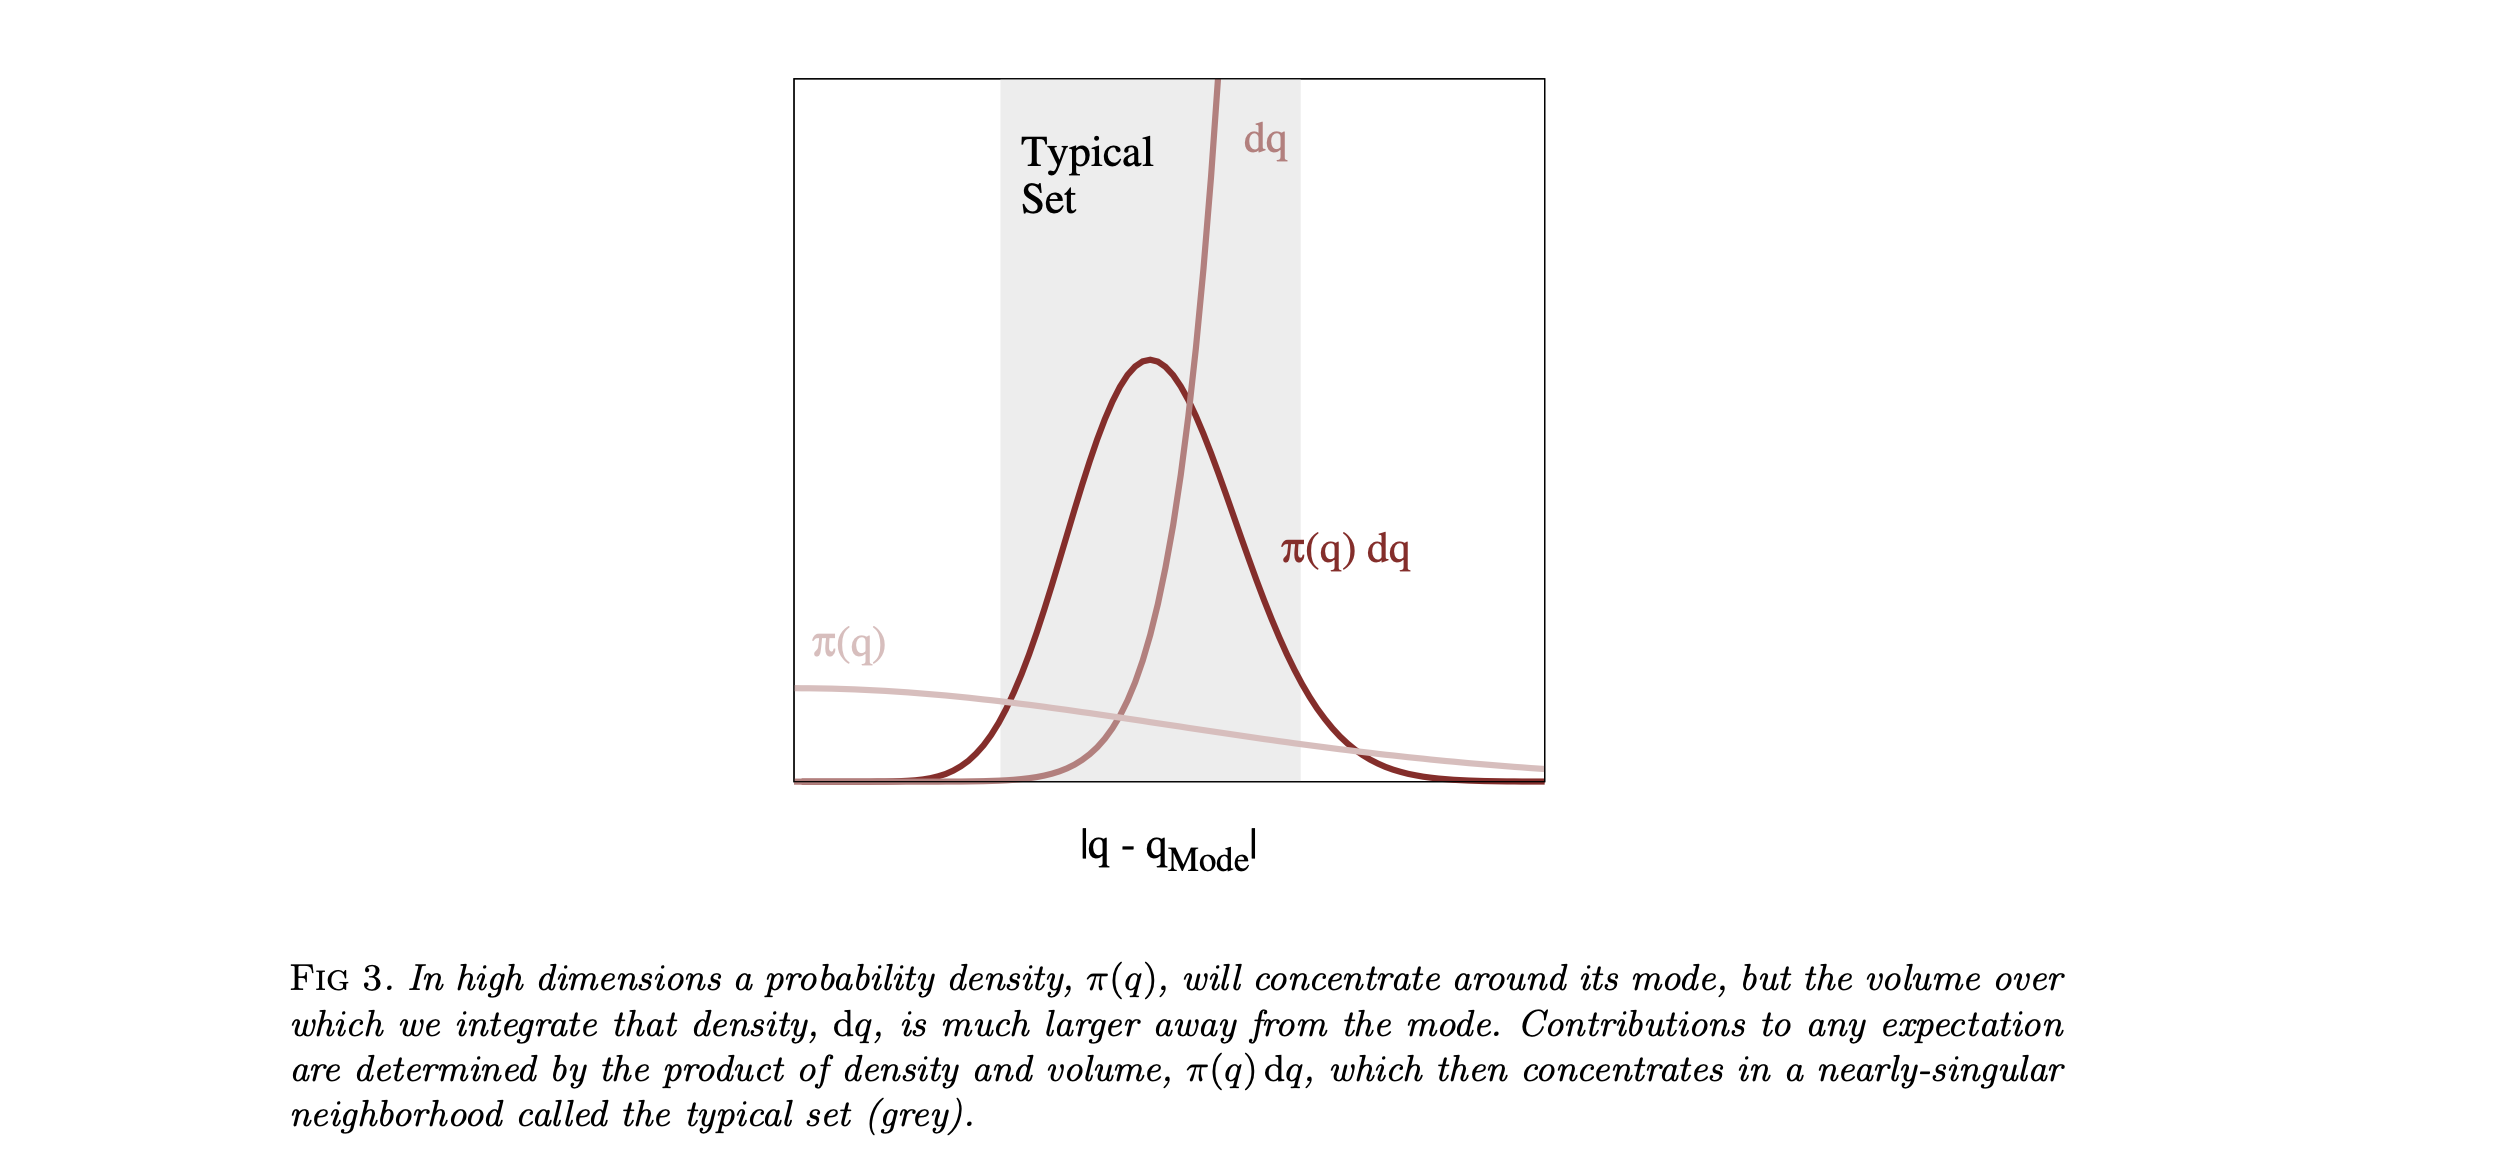

{% cite betancourt2017conceptual %}

- This may seem strange since it is difficult to intuit the behaviour in high dimensions. But it is true.

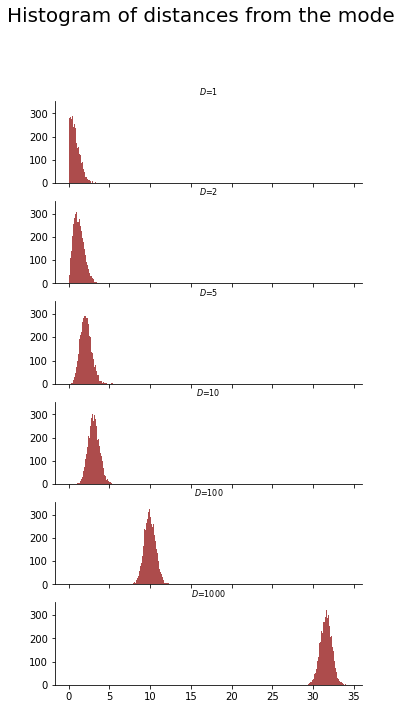

In [ ]:
#hide
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

D = [1,2,5,10,100,1000]
fig, axs = plt.subplots(len(D), figsize=(5, 10), sharex=True, sharey=True)
fig.tight_layout() 
fig.suptitle('Histogram of distances from the mode', fontsize=20)
plt.subplots_adjust(top=0.85)

for i,d in enumerate(D):
  mode = [0]*d
  q = np.random.multivariate_normal(mode, np.eye(d), 10000)
  dist = np.sqrt(np.sum(q**2, axis=1))
  axs[i].hist(dist, 100, color='darkred', alpha=0.7)
  axs[i].set_title(f'$D$={d}', fontsize=8)
  sns.despine()
plt.show();

# correct distance measure???

- The higher the dimension the thinner the typical set.
- Finding the thin typical set in a high dimensional space is difficult.

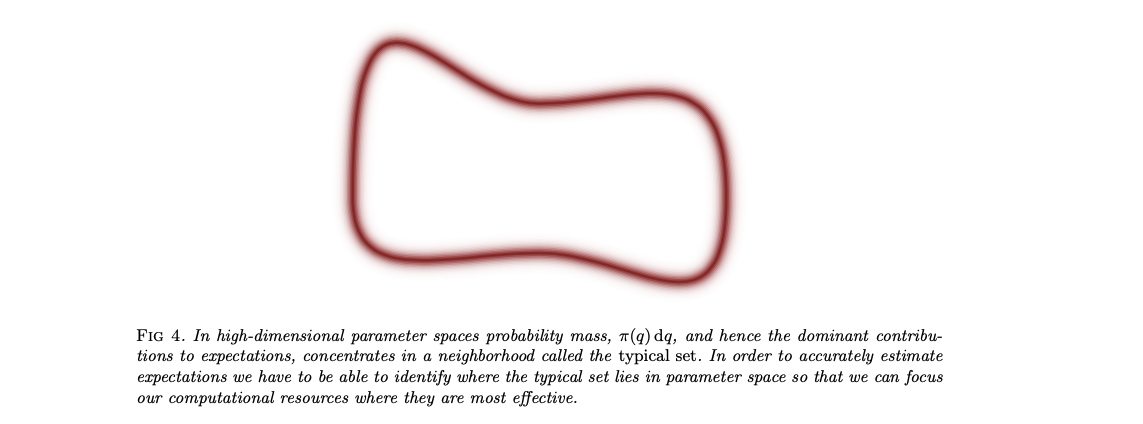

{% cite betancourt2017conceptual %}


- Use a Markov chain to find and stay within the typical set.
- Distribution of points we can jump to specified by Markov transition operator $\tau\left(q \mid q^{\prime}\right)$. 
- Needs to be engineered to satisfy $\pi(q)=\int \tau\left(q \mid q^{\prime}\right) \pi\left(q^{\prime}\right) \mathrm{d} q^{\prime}$
- In the limit MCMC is unbiased: $\lim _{N \rightarrow \infty} \frac{1}{N} \sum_{n=0}^{N} f\left(q_{n}\right) \rightarrow \mathbb{E}_{\pi}[f]$.
- Note that marginalization and higher moments are just expectations.

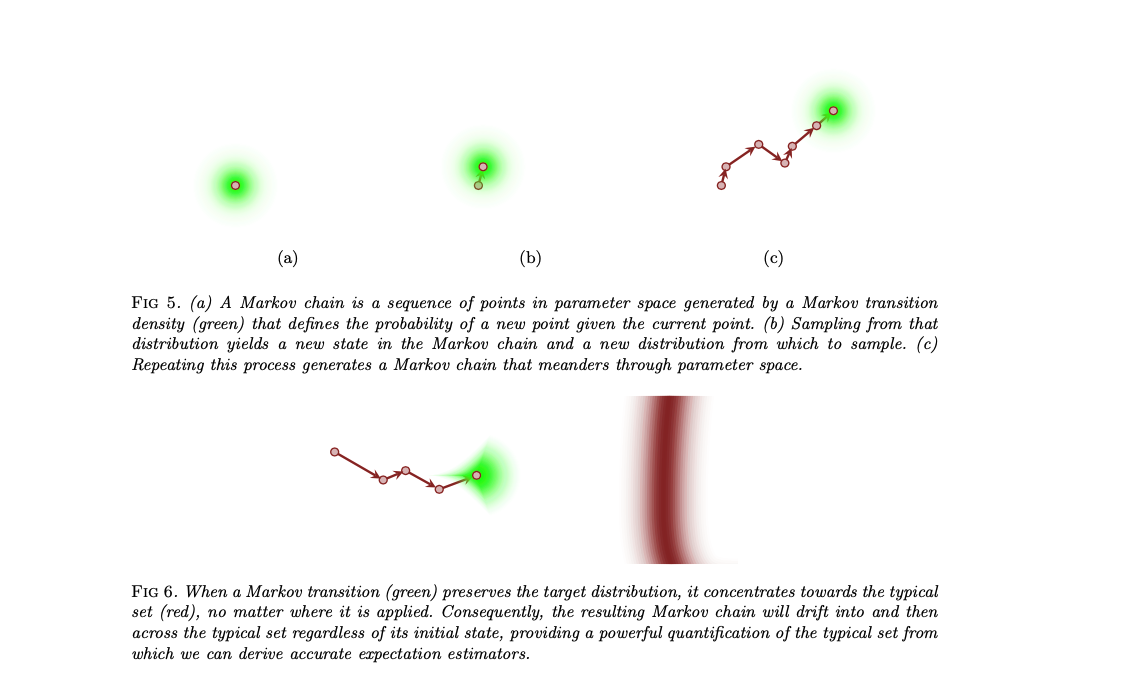

{% cite betancourt2017conceptual %}

- In the Random Walk Metropolis algorithm the transition distribution is given by \begin{equation}
\tau\left(q, q^{\prime}\right)=\mathcal{N}\left(q^{\prime} \mid q, \sigma^{2}\right) \min \left(1, \frac{\pi\left(q^{\prime}\right)}{\pi(q)}\right)
\end{equation}

- Random Walk Metropolis is inefficient since random proposals in high dimensions almost certainly do not remain in the typical set. Thus the rejection probability is exeedingly high.

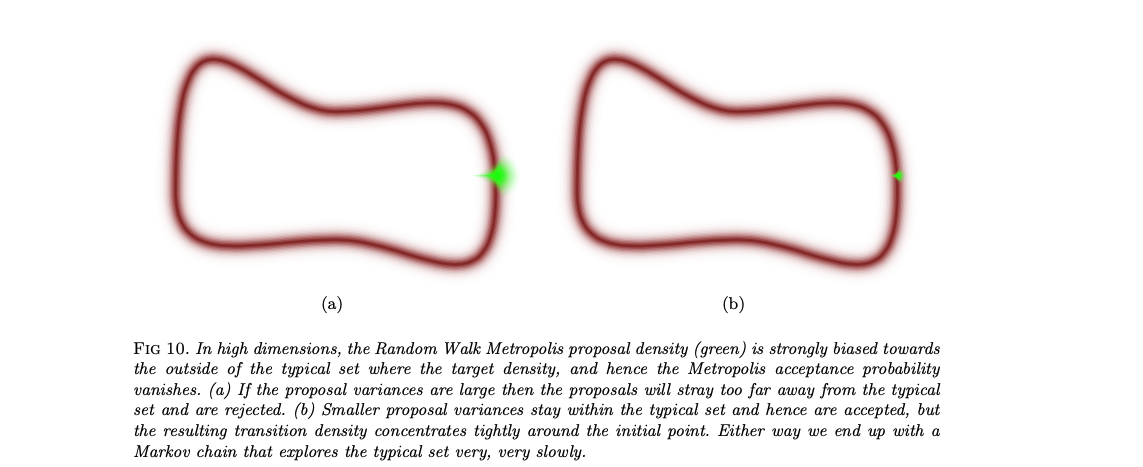

{% cite betancourt2017conceptual %}

- We need to exploit the geometry of the high dimensional surface to 'surf' the typical set.

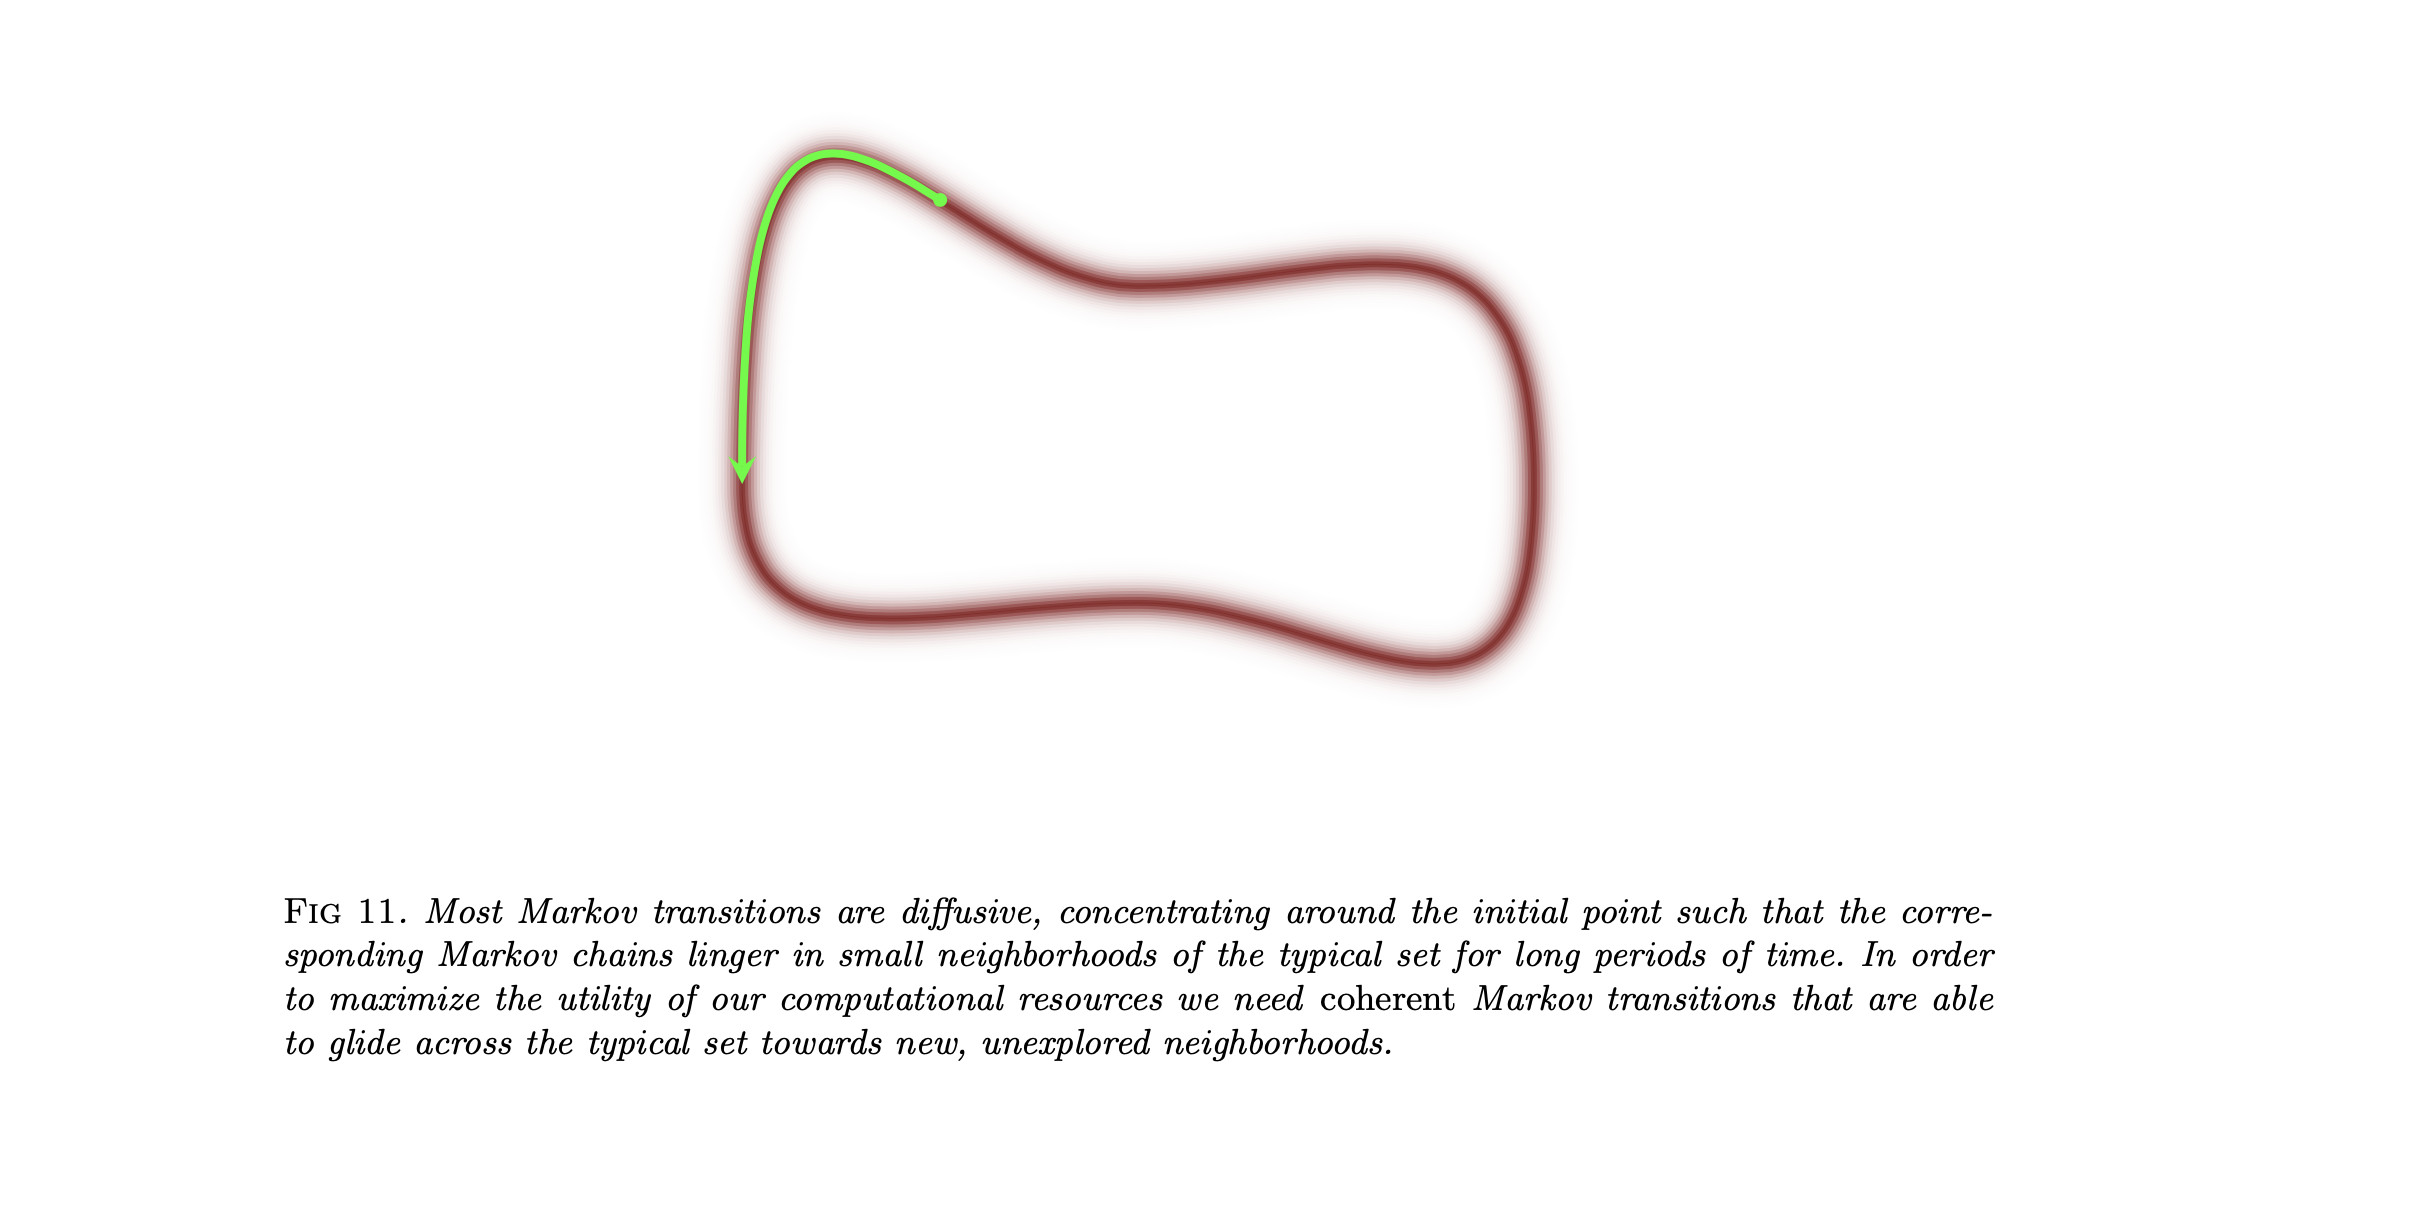

{% cite betancourt2017conceptual %}


- Nice visualization of different algorithms https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana
- For that we compute the gradient $\frac{\partial \pi(q)}{\partial q}$, ($\pi(q)$ is known up to a normalizing constant). 
- But $\frac{\partial \pi(q)}{\partial q}$ points to the mode. This is not what we need. (We do not optimize). We want to move along the typical set.
- The underlying mathematics to do so are the same as simulating the total energy of a frictionless ball rolling in a bowl that has the shape of the log-probability distribution turned on its head via the Hamiltonian $H(p, q)$ in classical physics.
- We construct a vector field aligned with the typical set using the Hamiltonian $H(p, q)$ based on $q$ and randomly sampled momentum $p \in \mathbb{R}^{D}$.

- Instead of just the position in sample space, we now need to consider a $2D$-dimensional phase space $q \rightarrow(p, q)$, and the joint distribution of the positions and momenta $\pi(q) = e^{-V(q)} \rightarrow \pi(p, q)=\pi(p \mid q) \pi(q) = e^{-H(q, p)}$.

- The Hamiltonian is given by \begin{equation}\begin{aligned} H(p, q) &=-\log \pi(p \mid q) \pi(q) \\ &=-\log \pi(p \mid q)-\log \pi(q)\\
&=: \quad K(p, q)+V(q) \end{aligned}\end{equation}

- We evolve the system with Hamilton's equations as follows:
\begin{equation}
\begin{aligned}
\frac{\mathrm{d} q}{\mathrm{d} t} &=+\frac{\partial H}{\partial p}=\frac{\partial K}{\partial p} \\
\frac{\mathrm{d} p}{\mathrm{d} t} &=-\frac{\partial H}{\partial q}=-\frac{\partial K}{\partial q}-\frac{\partial V}{\partial q}
\end{aligned}
\end{equation}
- The proposal behaves like a satelite in orbit around a planet.
- We need to add just the right amount of momentum in order to not crash into the mode or escape into infinity.

- Randomly sampled momenta facilitate a random walk between level sets. The vector field facilitates efficient exploration within the level set.  

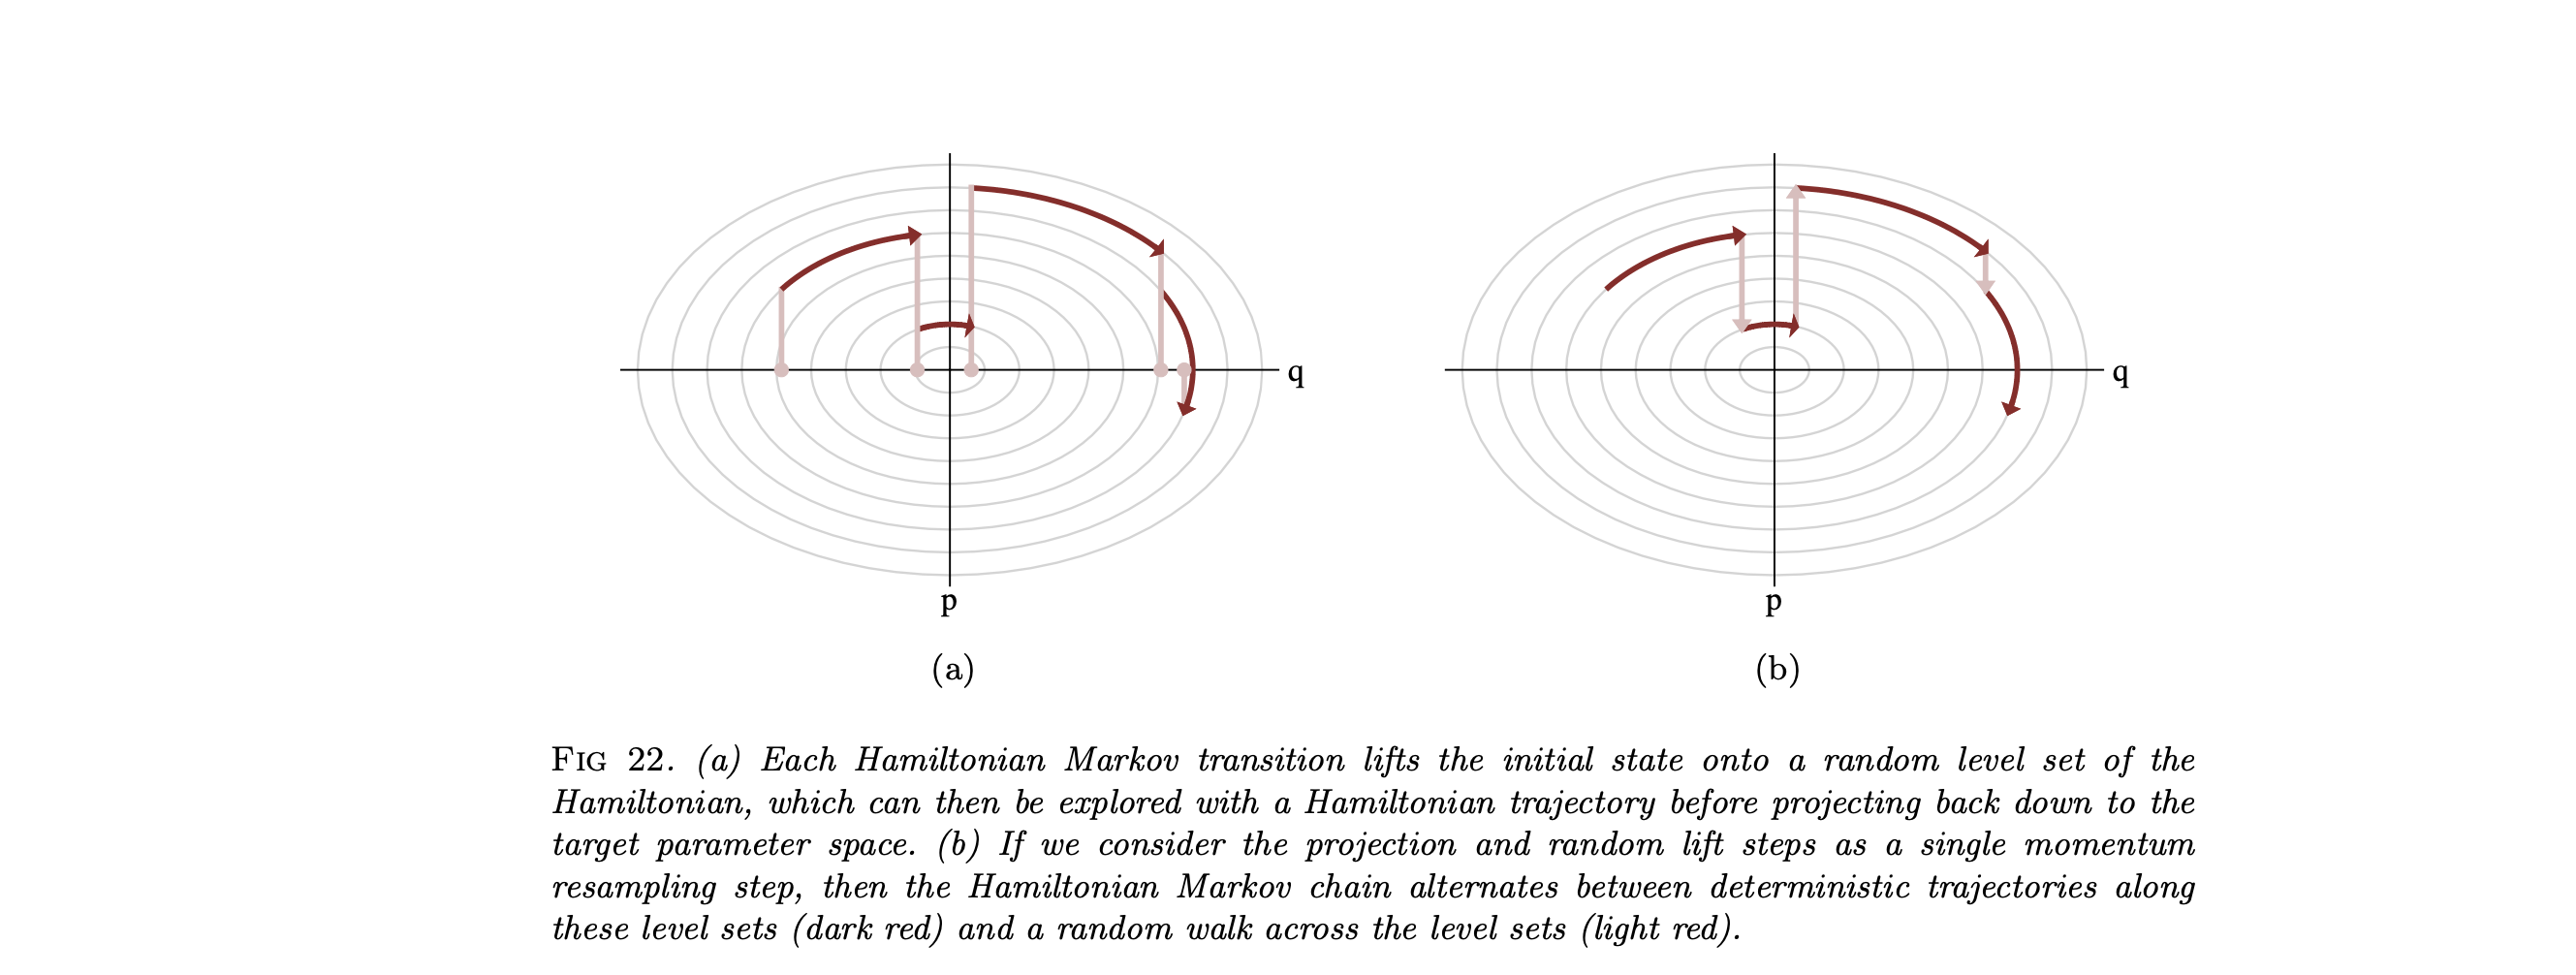

{% cite betancourt2017conceptual %}

- For how long should we simulate the trajectory of each momentum draw? Tradeoff:
  - exploit the geometric information as much as possible by staying on the trajectory
  - but not as long until we end up where we started. (E.g. No U-turn sampler (NUTS) {% cite hoffman2014no %}) 

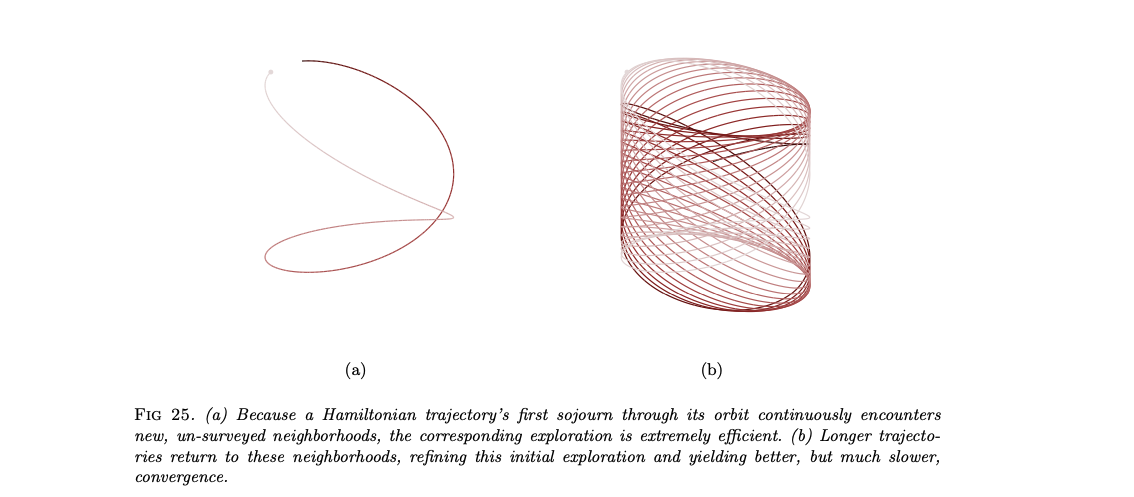

{% cite betancourt2017conceptual %}

- In practice we numerically approximate the trajectory using symplectic integrators, e.g. the Leapfrog method, which unlike other standard numerical methods do not introduce bias. 

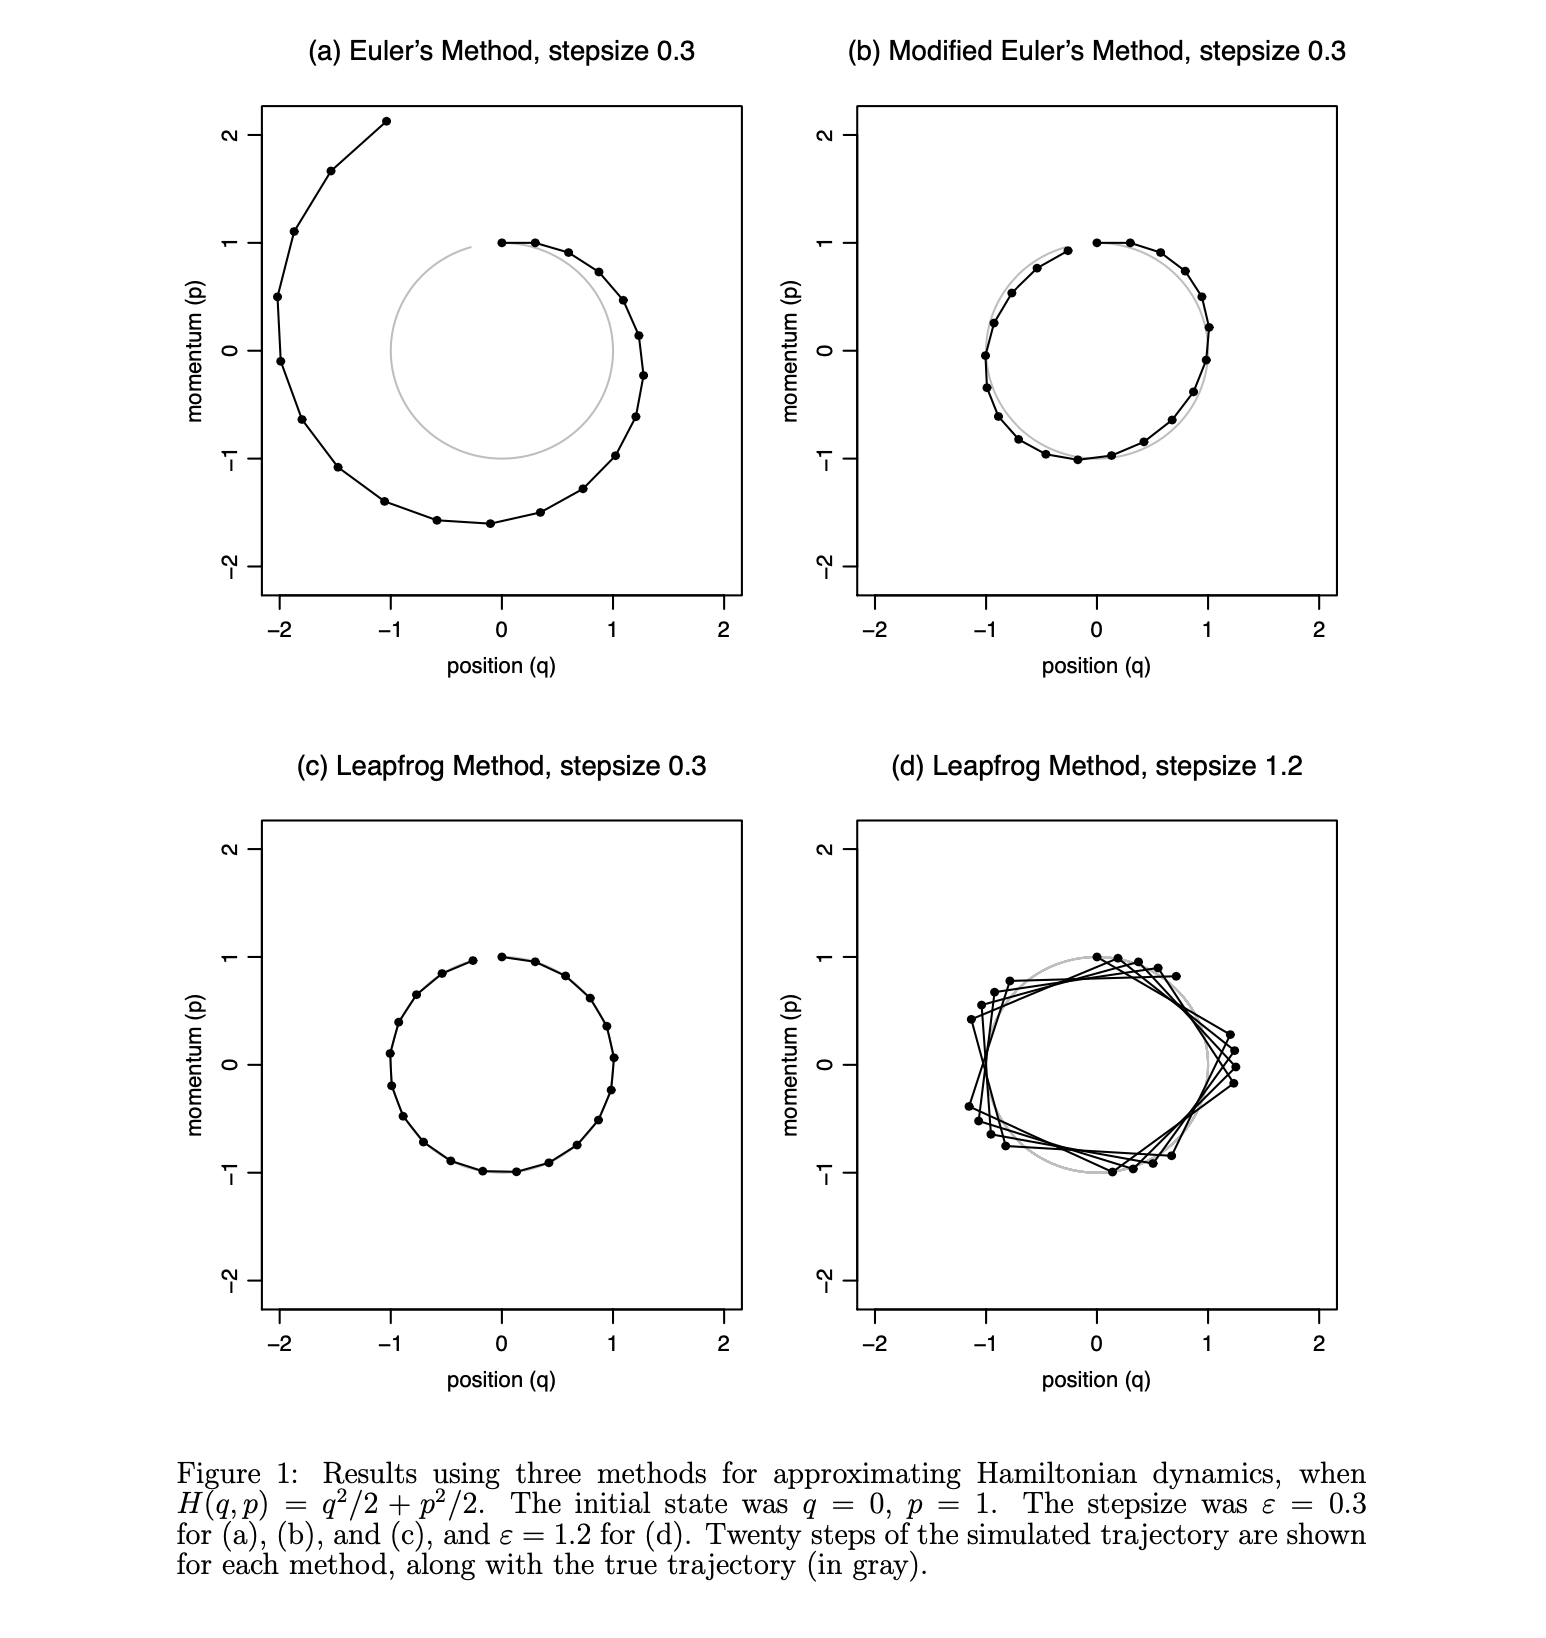

{% cite neal2011mcmc %}


- optimize step size $\epsilon$:
  - not too big so that rejection probability is too high.
  - not too small so that simulation is too expensive.

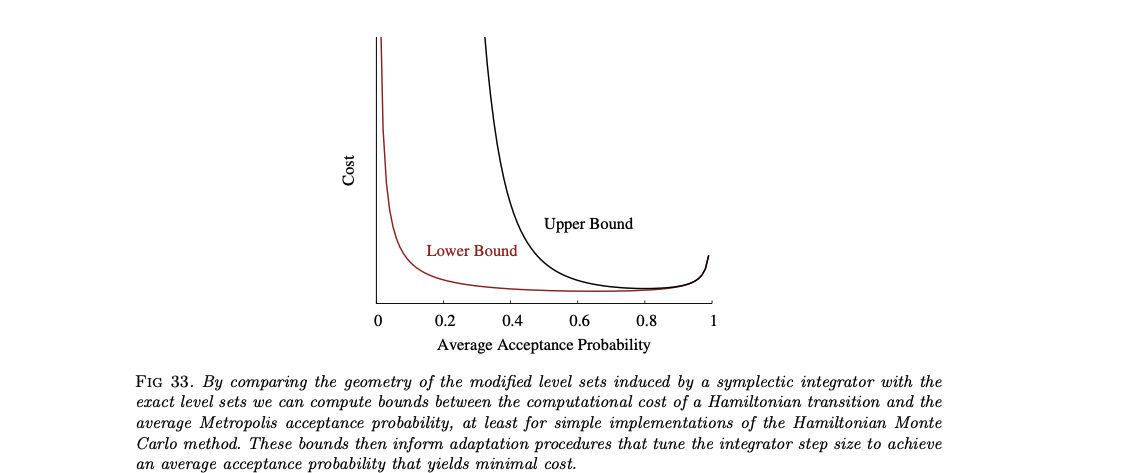

{% cite betancourt2017conceptual %}

- In theory the total energy given by $H$ is preserved so that **all proposals are accepted**. In practice however, we require a Metropolis-Hastings step to either accept or reject the proposed parameters to correct for any possible error due to approximating the dynamics with discrete steps.

\begin{equation}
\begin{array}{c}
q \rightarrow q+\epsilon \frac{\partial K}{\partial p} \\
p \rightarrow p-\epsilon\left(\frac{\partial K}{\partial q}+\frac{\partial V}{\partial q}\right) \\
\pi(a c c e p t)=\min \left(1, \frac{\pi\left(\Phi_{\tau}(p, q)\right)}{\pi(p, q)}\right)
\end{array}
\end{equation}

- When we choose the momentum distribution as multivariate Gaussian with covariance equal to the identity:
$$
K({p}, {q})=\frac{1}{2} {p}^{T} {p}+\mathrm{const.}
$$
so
$$
\frac{\partial K}{\partial {p}}={p}
$$
and
$$
\frac{\partial K}{\partial {q}}={0}
$$
Hamilton's equations simplify to:
$$
\begin{aligned}
\frac{d {q}}{d t} &={p} \\
\frac{d {p}}{d t}=&-\frac{\partial V}{\partial {q}}
\end{aligned}
$$ 

- So the update equations are:
\begin{equation}
\begin{array}{c}
q \rightarrow q+\epsilon p \\
p \rightarrow p-\epsilon\frac{\partial V}{\partial q} \\
\pi(a c c e p t)=\min \left(1, \frac{\pi\left(\Phi_{\tau}(p, q)\right)}{\pi(p, q)}\right)
\end{array}
\end{equation}

- The proposal for $q$ looks a lot like gradient descent with momentum (see https://distill.pub/2017/momentum/). 

- Langevin dynamics uses similar ideas. The proposal distribution is given by
$$
\tau\left(q^{\prime} \mid q\right)=\mathcal{N}\left(q+\frac{1}{2} \sigma^{2} \nabla \log \pi(q), \sigma^{2} I\right)
$$
- Then follows a Metropolis-Hastings step.
- Tries to move in directions of increasing $\pi(q)$
- Looks a lot like gradient descent with noise.

## Advantages

- Asymptotically unbiased. 
- Very efficient and principled way to draw samples from the posterior.
- When it fails it tells us.

## Current limitations

- Computing the gradient over the full data set is expensive if $n$ is large.
- There are fundamental obstructions using stochastic gradient (mini-batch) algorithms for scaling to large datasets (especially in wide data regimes).
   - {% cite betancourt2015fundamental %} 
   + {% cite chen2014stochastic %} use a friction term and a decreasing step size to counteract noise due to the stochastic gradient and avoid a Metropolis-Hastings step, which (over the full training set) would be prohibitively expensive. 
   + There are other approaches to scaling HMC that do **not** rely on SG {% cite cobb2020scaling %}.

## The future

- HMC is a general and uniquely positioned algorithm to efficiently sample from the posterior. Though current challenges exist in scaling this approach to very large data sets, future gains in computational power may alleviate these concerns.
- There are efforts to make SG-MCMC work for time series (i.e. dependent data) {% cite aicher2019stochastic %}, {% cite aicher2019nonlinear %}, {% cite gan2016scalable}. 
- {% cite zhang2019cyclical %} propose a cyclical step size to explore multi-modal posteriors of BNN more effectively. This is a cheap approximation to multi-chain HMC. They show improvements empirically on imagenet data scale.

## Implementation

In [ ]:
from autograd import grad
import autograd.numpy as np
import scipy.stats as st


class Metropolis:
  def __init__(self, log_p, q_0):
    self.q = q_0
    self.qs = [np.array(q_0)] 
    self.accepts = []
    self.log_p = log_p


  def metropolis_check(self, log_p_new, log_p_old):
    if np.log(np.random.rand()) <  log_p_new - log_p_old:
      self.accept = True
    else:
      self.accept = False
      self.q = np.copy(self.qs[-1])


  def sample(self, n_samples):
    for _ in range(n_samples):
      # 1. propose q
      self.q = self.qs[-1] + np.random.normal(0,1)
      # 2. Metropolis check 
      self.metropolis_check(self.log_p(self.q), self.log_p(self.qs[-1]))
      # append to samples
      self.qs.append(self.q)
      self.accepts.append(self.accept)

class HMC(Metropolis):
  def __init__(self, log_p, q_0):
    super().__init__(log_p, q_0)
    # Momentum dist \pi(\mathbf{p} \mid \mathbf{q})=\mathcal{N}(\mathbf{0}, I)
    self.mom = st.norm(0, 1)
    # List of momenta
    self.ps = [self.mom.rvs(1)]
    # Gradient of the potential energy w.r.t. q
    self.dVdq = grad(lambda x: -self.log_p(x))

  
  def sample(self, n_samples, path_len, step_size):
    for _ in range(n_samples):
      # 1. resample momentum from N(0,1)
      self.p = self.mom.rvs(1)
      # 2. simulate system with numerical integrator
      energy_start = self.log_joint_p(self.q, self.p)
      self.leapfrog(path_len, step_size)
      energy_end = self.log_joint_p(self.q, self.p)
      # 3. check that numerical integrator conserved energy
      self.metropolis_check(energy_start, energy_end)
      # append to the sample lists
      self.qs.append(self.q)
      self.accepts.append(self.accept)
      self.ps.append(self.p) if self.accept else self.ps.append(self.ps[-1])


  def log_joint_p(self, q, p):
    """log\pi(q, p)"""
    return self.log_p(q) + np.sum(self.mom.logpdf(p))


  def leapfrog(self, path_len, step_size):
      """Leapfrog integrator.
      """
      q, p = np.copy(self.q), np.copy(self.p)
      p -= step_size * self.dVdq(q) / 2
      for _ in range(int(path_len / step_size) - 1):
        q += step_size * p
        p -= step_size * self.dVdq(q)
      q += step_size * p
      p -= step_size * self.dVdq(q) / 2
      self.q, self.p = q, -p



In [ ]:
def log_p_normal(mu, sigma):
    """
    logp(x | mu, sigma) = -0.5 * (log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2)
    """
    def logp(x):
        return -0.5 * (np.log(2 * np.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)
    return logp

In [ ]:
n_samples = 10000
sampler = HMC(log_p_normal(0,1), np.array([0.]))
sampler.sample(n_samples, step_size=0.1, path_len=1)


In [ ]:
p_accept = np.array(sampler.accepts, dtype=int).mean()
print('HMC acceptance probability:', p_accept)

HMC acceptance probability: 0.9993


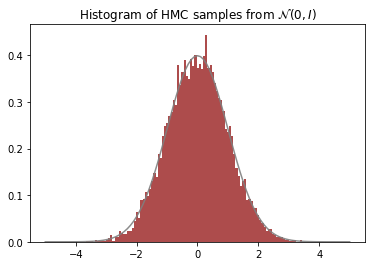

In [ ]:
plt.hist(np.array(sampler.qs[1:]).flatten(), 100, density=True, color='darkred', alpha=0.7)
x = np.linspace(-5,5,101)
plt.plot(x, st.norm(0,1).pdf(x), color='gray', alpha=0.9)
plt.title('Histogram of HMC samples from $\mathcal{N}(0, I)$');

In [ ]:
n_samples = 10000
sampler = Metropolis(log_p_normal(0,1), 0.)

sampler.sample(n_samples)

In [ ]:
p_accept = np.array(sampler.accepts, dtype=int).mean()
print('RWM acceptance probability:', p_accept)

RWM acceptance probability: 0.7079


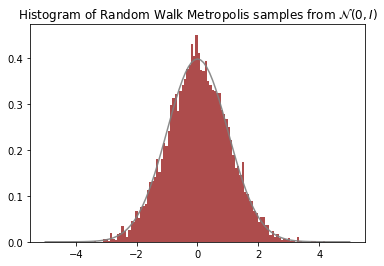

In [ ]:
plt.hist(np.array(sampler.qs[1:]).flatten(), 100, density=True, color='darkred', alpha=0.7)
x = np.linspace(-5,5,101)
plt.plot(x, st.norm(0,1).pdf(x), color='gray', alpha=0.9)
plt.title('Histogram of Random Walk Metropolis samples from $\mathcal{N}(0, I)$');

In one dimension, HMC is not advantageous relative to RWM. But in high dimensions, most proposals of RWM will be rejected while HMC will still accept most of them. Note the HMC acceptance probability of almost 1 in the example above! 

# Variational Inference


- We are again interested in the posterior $p(z \mid x, \alpha)=\frac{p(z, x \mid \alpha)}{\int_{z} p(z, x \mid \alpha)}$.
- Assume that $x=x_{1: n}$ are observations and $z=z_{1: m}$ are hidden variables (e.g. parameters). We assume additional parameters $\alpha$ that are fixed (e.g. hyperparameters).
- The evidence $$\int_{z} p(z, x \mid \alpha)$$ is intractable.
- VI turns inference into optimization problem.
- Posit a variational family of distributions over the parameters 
$$q\left(z_{1: m} \mid \nu\right),$$ which has nice properties so that computing the needed expectations is tractable.
- Note that this restriction is why VI is generally not unbiased.
- Fit the variational parameters $\nu$ such that the KL divergence between the parameterized variational distribution and the posterior is minimized.
- Problem is: how to do this minimization if the input $p(z \mid x)$ is intractable? Is is the reason we are doing the optimization after all.
- Solution: *maximize* the Evidence Lower BOund (ELBO), which, as the name suggests, is a lower bound on the (log) evidence.


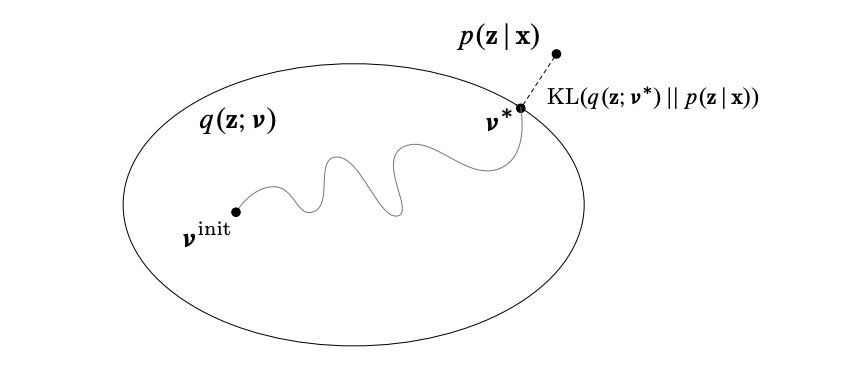

- The ELBO can be derived as follows:
\begin{equation}
\begin{aligned}
\log p(x) &=\log \int_{z} p(x, z) \\
&=\log \int_{z} p(x, z) \frac{q(z)}{q(z)} \\
&=\log \left(\mathrm{E}_{q}\left[\frac{p(x, z)}{q(z)}\right]\right) \\
& \geq \mathrm{E}_{q}[\log p(x, z)]-\mathrm{E}_{q}[\log q(z)] =: \text{ELBO},
\end{aligned}
\end{equation} where the inequality follows from Jensen's inequality.
- Note that the second term of the ELBO, $- \mathrm{E}_{q}[\log q(z)]$, is the entropy.

- Why does maximizing the ELBO yield the same optimal variational parameters as minimizing the KL divergence? Because the KL divergence is equal to the negative ELBO plus the log evidence $\log p(x)$ (which does not depend on $q$):
\begin{equation}
\begin{aligned}
\operatorname{KL}(q(z) \| p(z \mid x)) &=\mathrm{E}_{q}\left[\log \frac{q(z)}{p(z \mid x)}\right] \\
&=\mathrm{E}_{q}[\log q(z)]-\mathrm{E}_{q}[\log p(z \mid x)] \\
&=\mathrm{E}_{q}[\log q(z)]-\mathrm{E}_{q}[\log p(z, x)]+\log p(x) \\
&=-\left(\mathrm{E}_{q}[\log p(z, x)]-\mathrm{E}_{q}[\log q(z)]\right)+\log p(x) \\
&= - \text{ELBO} +\log p(x)
\end{aligned}
\end{equation}

- Note that maximizing the ELBO is a tradeoff between the MAP estimate and the prior:
\begin{equation}
\begin{aligned}
\text{ELBO} &=  \mathrm{E}_{q}[\log p(x, z)]-\mathrm{E}_{q}[\log q(z)] \\
&= \mathrm{E}_{q}[\log p(x \mid z) p(z)]-\mathrm{E}_{q}[\log q(z)] \\
&= \mathrm{E}_{q}[\log p(x \mid z)] - \mathrm{E}_{q}[\log \frac{q(z)}{p(z)}]\\
&= \mathrm{E}_{q}[\log p(x \mid z)] - \operatorname{KL}(q(z) \| p(z))
\end{aligned}
\end{equation}
- The first term is maximized with a Dirac delta function at the MAP or maximum likelihood estimate of $z$. 
- The second term is the negative KL divergence of the variational distribution and the prior.

- There are several ways to do the optimization, e.g.:
  - Mean field approximation
  - Stochastic variational inference
  - Black box variational inference


## Advantages
- Efficient and scalable to huge datasets.

## Limitations
- Is asymtotically not unbiased.
- Finds a unimodal approximation (use ensembeles).
- Currently deep ensembles do better than VI (but ensembling VI probably is better still).


# References

{% bibliography --cited %}